In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
using LinearAlgebra
using ForwardDiff
using BlockDiagonals
using ControlSystems
using OSQP
using SparseArrays
using PyPlot


  Activating environment at `C:\Users\beeda\School_docs\16-745\Project.toml`


In [2]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end

qtorp (generic function with 1 method)

In [3]:
#Quadrotor parameters
m = 0.5
ℓ = 0.1750
J = Diagonal([0.0023, 0.0023, 0.004])
g = 9.81
kt=1.0
km=0.0245

h = 0.05 #20 Hz

Nx = 13     # number of states (quaternion)
Nu = 4     # number of controls

Tfinal = 50.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [4]:
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [5]:
function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
    
    ω̇ = J\(-hat(ω)*J*ω + [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]*u)
    
    return [ṙ; q̇; v̇; ω̇]
end

quad_dynamics (generic function with 1 method)

In [6]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [7]:
#Initial Conditions
u_hover = (m*g/4)*ones(4)
r0 = [1; 0; 0]
q0 = [1; 0; 0; 0]
v0 = zeros(3)
ω0 = zeros(3)
x0 = [r0; q0; v0; ω0];

In [8]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,u_hover),x0)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x0,u),u_hover);

In [9]:
A_12 = Array(E(q0)'*A*E(q0))
B_12 = Array(E(q0)'*B);

In [10]:
A

13×13 Matrix{Float64}:
 1.0  0.0  0.0   0.0        0.0       …   0.0          0.000204375  0.0
 0.0  1.0  0.0   0.0       -0.024525     -0.000204375  0.0          0.0
 0.0  0.0  1.0  -0.024525   0.0           0.0          0.0          0.0
 0.0  0.0  0.0   0.0        0.0           0.0          0.0          0.0
 0.0  0.0  0.0   0.0        1.0           0.025        0.0          0.0
 0.0  0.0  0.0   0.0        0.0       …   0.0          0.025        0.0
 0.0  0.0  0.0   0.0        0.0           0.0          0.0          0.025
 0.0  0.0  0.0   0.0        0.0           0.0          0.0122625    0.0
 0.0  0.0  0.0   0.0       -0.981        -0.0122625    0.0          0.0
 0.0  0.0  0.0  -0.981      0.0           0.0          0.0          0.0
 0.0  0.0  0.0   0.0        0.0       …   1.0          0.0          0.0
 0.0  0.0  0.0   0.0        0.0           0.0          1.0          0.0
 0.0  0.0  0.0   0.0        0.0           0.0          0.0          1.0

In [11]:
A_12

12×12 Matrix{Float64}:
 1.0  0.0  0.0   0.0       0.024525  0.0  …   0.0          0.000204375  0.0
 0.0  1.0  0.0  -0.024525  0.0       0.0     -0.000204375  0.0          0.0
 0.0  0.0  1.0   0.0       0.0       0.0      0.0          0.0          0.0
 0.0  0.0  0.0   1.0       0.0       0.0      0.025        0.0          0.0
 0.0  0.0  0.0   0.0       1.0       0.0      0.0          0.025        0.0
 0.0  0.0  0.0   0.0       0.0       1.0  …   0.0          0.0          0.025
 0.0  0.0  0.0   0.0       0.981     0.0      0.0          0.0122625    0.0
 0.0  0.0  0.0  -0.981     0.0       0.0     -0.0122625    0.0          0.0
 0.0  0.0  0.0   0.0       0.0       0.0      0.0          0.0          0.0
 0.0  0.0  0.0   0.0       0.0       0.0      1.0          0.0          0.0
 0.0  0.0  0.0   0.0       0.0       0.0  …   0.0          1.0          0.0
 0.0  0.0  0.0   0.0       0.0       0.0      0.0          0.0          1.0

In [12]:
# Cost weights
Q = Array(I(12));
R = Array(I(4));

#Thrust limits
umin = [0.2*m*g; 0.2*m*g;0.2*m*g; 0.2*m*g]
umax = [0.6*m*g; 0.6*m*g;0.6*m*g; 0.6*m*g]

4-element Vector{Float64}:
 2.943
 2.943
 2.943
 2.943

In [13]:
#Build QP matrices for OSQP

Nx = 12
Nh = 50 #one second horizon at 20Hz
U = kron(Diagonal(I,Nh), [I zeros(Nu,Nx)]) #Matrix that picks out all u
Θ = kron(Diagonal(I,Nh), [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]) #Matrix that picks out all x3 (θ)
HH = sparse([kron(Diagonal(I,Nh-1),[R zeros(Nu,Nx); zeros(Nx,Nu) Q*10000000]) zeros((Nx+Nu)*(Nh-1), Nx+Nu); zeros(Nx+Nu,(Nx+Nu)*(Nh-1)) [R zeros(Nu,Nx); zeros(Nx,Nu) 10000000*Q]])
b = zeros(Nh*(Nx+Nu))
C = sparse([[B_12 -I zeros(Nx,(Nh-1)*(Nu+Nx))]; zeros(Nx*(Nh-1),Nu) [kron(Diagonal(I,Nh-1), [A_12 B_12]) zeros((Nh-1)*Nx,Nx)] + [zeros((Nh-1)*Nx,Nx) kron(Diagonal(I,Nh-1),[zeros(Nx,Nu) Diagonal(-I,Nx)])]])

#Dynamics + Thrust limit constraints
# D = [C; U]
# lb = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover)]
# ub = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover)]

#Dynamics + thrust limit + bound constraint on θ to keep the system within small-angle approximation
D = [C; U; Θ]
lb = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover); -0*ones(Nh)]
ub = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover); 0*ones(Nh)]

prob = OSQP.Model()
OSQP.setup!(prob; P=HH, q=b, A=D, l=lb, u=ub, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);

In [14]:
function mpc_controller(x,xref)
    
    q0 = x0[4:7]
    q = x[4:7]
    ϕ = qtorp(L(q0)'*q)  
    
    r0 = xref[1:3]
    v0 = xref[7:9]
    ω0 = xref[10:12]
    
    Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
    
    #Update QP problem
    lb[1:12] .= -A_12*Δx̃
    ub[1:12] .= -A_12*Δx̃
    
    
#     for j = 1:(Nh-1)
#         b[(Nu+(j-1)*(Nx+Nu)).+(1:Nx)] .= -Q*xref
#     end
#     b[(Nu+(Nh-1)*(Nx+Nu)).+(1:Nx)] .= -P*xref
    
    
    
    OSQP.update!(prob, q=b, l=lb, u=ub)

    #Solve QP
    results = OSQP.solve!(prob)
    Δu = results.x[1:Nu]

    return u_hover + Δu
end

mpc_controller (generic function with 1 method)

In [16]:
#Simulation


Nx = 13
uhist = zeros(Nu,Nt);
xhist = zeros(Nx,Nt);
xhist[:,1] = x0
r = 1
z0 = 2

for k = 1:(Nt-1)
    t = k*(2*pi)/(Nt)
    x = r*cos(t)
    y = r*sin(t)
    xref = [x, y, z0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    uhist[:,k] = mpc_controller(xhist[:,k],xref)
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],uhist[:,k])
end

In [17]:
function f(x)
    r = x[1:3]
    q = x[4:7]
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
   
    fr = Q*v
    fq = 0.5*L(q)*H*ω
   
    fv = Q'*[0; 0; -g] - hat(ω)*v
    fω = J\(-hat(ω)*J*ω)
   
    return [fr; fq; fv; fω]
end

function gc(x)
   
    gr = zeros(3, 4)
    gq = zeros(4, 4)
    gv = (1/m)*[zeros(2,4); kt*ones(1,4)] # this is 3x4
    gω = J\( [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]) # should also be 3x4
   
    return [gr; gq; gv; gω]
end

gc (generic function with 1 method)

In [18]:
xhist[:,:]

13×1001 Matrix{Float64}:
 1.0   1.0           1.0           1.0          …   0.972336      0.97354
 0.0   5.30892e-11   8.22766e-10   1.5681e-6       -0.194864     -0.188757
 0.0   0.0171675     0.06867       0.148639         2.0           2.0
 1.0   1.0           1.0           1.0              1.0           1.0
 0.0  -5.41174e-9   -1.89293e-8   -0.000199245     -0.000156525  -0.00015162
 0.0  -1.69845e-11  -6.92621e-11  -1.87589e-6   …  -0.000781031  -0.000781998
 0.0  -4.33681e-18  -1.72584e-17   2.71333e-14      1.92569e-7    1.92569e-7
 0.0   9.9971e-12    8.25744e-11   5.66945e-6       0.0244629     0.0236962
 0.0  -3.18535e-9   -2.01507e-8   -0.000602136      0.122065      0.122216
 0.0   0.6867        1.3734        1.82534          4.59084e-15   4.99926e-15
 0.0  -4.32939e-7   -6.48462e-7   -0.0159375    …   0.000196099   0.000196342
 0.0  -1.35876e-9   -2.82344e-9   -0.000150063     -3.93e-5      -3.80681e-5
 0.0  -3.46945e-16  -6.93889e-16   8.67362e-17     -1.5931e-7    -1.59

In [19]:
x0


13-element Vector{Float64}:
 1.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [20]:
## CBF: Build QP matrices for OSQP
itr = 1

x_now = x0
all_x = zeros(13,1001)
all_u = zeros(4, 1001)


for i = 1:1001 ################################################################################################################################

    Unom = uhist[:,i]
#LgLfhx = -2/m*(x_now[3]-1)*ones(4,1)
#LfLfhx = f(x_now)'*[-2*x_now[8]; -2*x_now[9]; -2*x_now[10]; zeros(4); -2*x_now[1]; -2*(x_now[2] - 1) ; -2*(x_now[3]-1) ; zeros(3)]
#Kn = [0 , 0]
#Lfhx = f(x_now)'*[-2*x_now[1];-2*(x_now[2]-1);-2*(x_now[3]-1);zeros(10)]
#hx = 0.1 - x_now[1]^2 - (x_now[2]-1)^2 - (x_now[3]-1)^2
#ηx = [hx; Lfhx]
    hx = x_now[1]^2 + (x_now[2]-1)^2 + (x_now[3]-2)^2 - 0.5^2
    Lfhx = f(x_now)'*[2*x_now[1];2*(x_now[2]-1);2*(x_now[3]-2);zeros(10)]
    ηx = [hx; Lfhx]
    Kn = [1.65 , 1.65]
    LfLfhx = f(x_now)'*[2*x_now[8]; 2*x_now[9]; 2*x_now[10]; zeros(4); 2*x_now[1]; 2*(x_now[2] - 1) ; 2*(x_now[3]-2) ; zeros(3)]
    LgLfhx = 2/m*(x_now[3]-1)*ones(4,1)
    #dhdx = [-2*x_now[1]; -2*(x_now[2]-1); -2*(x_now[3]-1); zeros(10)]
    #d2hdx2 = [-2 zeros(1, 12); 0 -2 zeros(1, 11); 0 0 -2 zeros(1, 10); zeros(10, 13)]
    #Lfhx = x_now'*A'*dhdx
    #dlfhxfx = A*dhdx + d2hdx2'*A'*x_now
    #LfLfhx = x_now'*A'*dlfhxfx
    #println(LfLfhx)
    #LgLfhx = B'*dlfhxfx
    #Kn = [0.1 0.1]
    #ηx = [hx; Lfhx]
    

# @show LgLfhx
    
    HH = sparse([0 0 0 0 0 0 0 0;
                 0 0 0 0 0 0 0 0;
                 0 0 0 0 0 0 0 0;
                 0 0 0 0 0 0 0 0;
                 0 0 0 0 1 0 0 0;
                 0 0 0 0 0 1 0 0;
                 0 0 0 0 0 0 1 0;
                 0 0 0 0 0 0 0 1])

    b = zeros(8)

    D = [1.0*I(4)  -1.0*I(4) ;  LgLfhx'  zeros(1, 4)]
    lb = [Unom; -Kn'*ηx.-LfLfhx]
    ub = [Unom; Inf]

    prob = OSQP.Model()
    OSQP.setup!(prob; P=HH, q=b, A=D, l=lb, u=ub, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);
    
    results = OSQP.solve!(prob)
    println(hx)
    u = results.x[1:4]
    if norm(u) > 1e5
        println("control too large!")
        break;
    end
    all_u[:,i] .= u 
    all_x[:,i] .= x_now
    x_now = quad_dynamics_rk4(x_now,u)

end ################################################################################################################################

5.75
5.6816247229497385
5.483848681250916
5.188507578616774
4.873052326316944
4.5871359854085245
4.327927582449055
4.092855727932669
3.879585758715364
3.6859990231845865
3.5101741166113607
3.3503698252855054
3.2050095697807914
3.0726671693015137
2.9520537755388188
2.84200584737711
2.741474057938769
2.6495130433882346
2.565271918853621
2.4879855007376417
2.4169661864489855
2.3515964520923074
2.2913219356600565
2.2356450782757937
2.1841192987459843
2.136343677827034
2.0919581284645528
2.050639027240959
2.01209528085163
1.976064799918452
1.9423113511731853
1.9106217581509015
1.8808034201771506
1.8526821196072372
1.826100088004893
1.8009143031279087
1.776994990172851
1.7542243025873496
1.7324951598202016
1.7117102215267064
1.6917809799255954
1.67262695412552
1.6541749722739318
1.6363585292730172
1.6191172095499375
1.60239616593222
1.5861456470743125
1.5703205670965426
1.5548801121530456
1.5397873795403316
1.5250090457157979
1.5105150602225519
1.4962783630345657
1.4822746232528583
1.4684819

4.8537351591139775
4.867420853139251
4.881057423001394
4.894644533743174
4.908181852663028
4.921669049328164
4.935105795587584
4.9484917655850165
4.961826635771747
4.97511008491937
4.988341794132451
5.001521446861074
5.0146487289133335
5.027723328467701
5.040744936085317
5.0537132447221715
5.066627949741219
5.079488748924369
5.092295342484389
5.105047433076731
5.117744725811236
5.1303869282637535
5.142973750487666
5.155504905025311
5.167980106919306
5.180399073723775
5.192761525515483
5.205067184904854
5.21731577704691
5.229507029652094
5.241640672997003
5.2537164399350065
5.26573406590678
5.277693288950725
5.289593849713292
5.301435491459197
5.313217960081535
5.324941004111801
5.336604374729783
5.348207825773374
5.359751113748277
5.3712339978375825
5.382656239911273
5.3940176045355885
5.405317858982323
5.416556773237973
5.427734120012812
5.4388496747498465
5.449903215633657
5.460894523599138
5.471823382340134
5.48268957831796
5.493492900769813
5.504233141717073
5.514910095973509
5.525

In [21]:
maximum(all_x[3,:])

1.8033918241871272

In [22]:
all_x[1:3,:]

3×1001 Matrix{Float64}:
 1.0  1.0          1.0          …   0.971094   0.972336    0.97354
 0.0  5.30892e-11  8.04077e-10     -0.200963  -0.194864   -0.188757
 0.0  0.0171675    0.0676831        0.033066   0.0310921   0.0291183

In [23]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

LoadError: ArgumentError: Package TrajOptPlots not found in current path:
- Run `import Pkg; Pkg.add("TrajOptPlots")` to install the TrajOptPlots package.


In [24]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

LoadError: UndefVarError: Quadrotor not defined

In [25]:
X1 = [SVector{13}(x) for x in eachcol(xhist)];
visualize!(vis, model, thist[end], X1)

LoadError: UndefVarError: SVector not defined

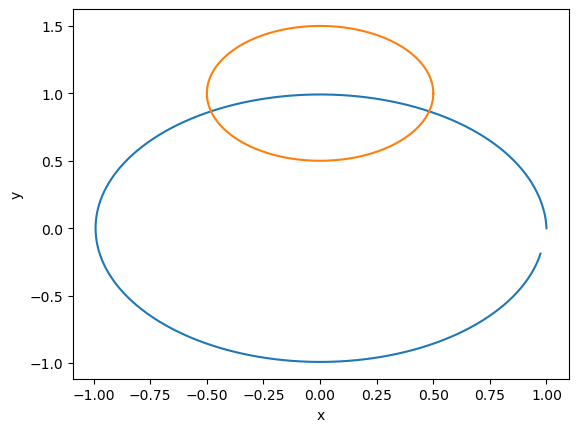

PyObject Text(24.000000000000007, 0.5, 'y')

In [26]:
t = collect(0:0.05:50)
u = t*2*pi/50
xc = 0.5*cos.(u)
yc = 1 .+ 0.5*sin.(u)
plot(all_x[1,:], all_x[2,:])
plot(xc,yc)
xlabel("x"); ylabel("y")

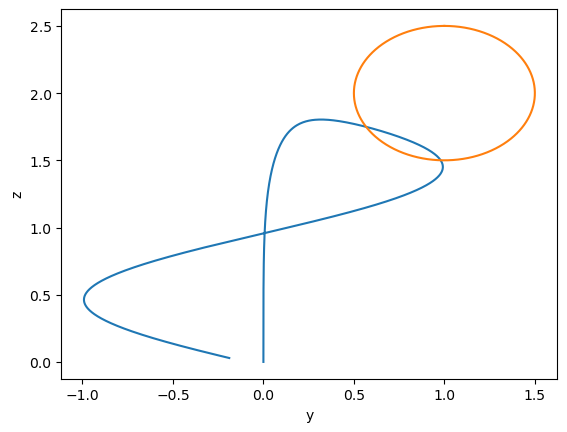

PyObject Text(24.000000000000007, 0.5, 'z')

In [27]:
zc = 2 .+ 0.5*cos.(u)
plot(all_x[2,:], all_x[3,:]) 
plot(yc, zc)
xlabel("y")
ylabel("z")

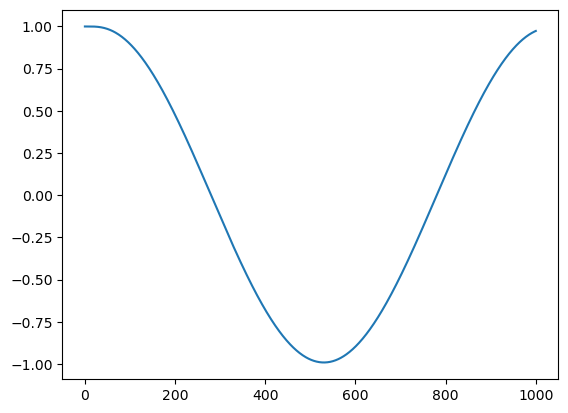

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000068F57BB0>

In [28]:
plot(all_x[1,:])

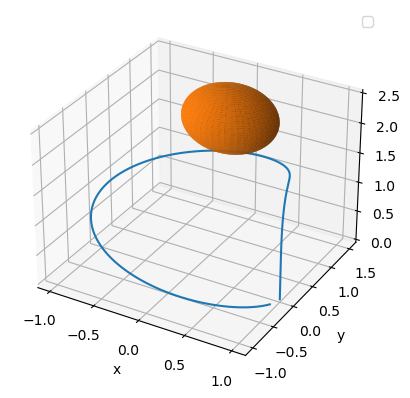

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [29]:
#1. ref traj .. tracking 
#2. cbfs setup.. quadratic maybe
#3. derive the input conditions for the cbf
#4. 

#plot(xhist[1,:],xhist[2,:])
plot3D(all_x[1,:], all_x[2,:], all_x[3,:])
v = t*pi/50
x_sphere = 0.5*cos.(u) * sin.(v)'
y_sphere = 1 .+ 0.5*sin.(u) * sin.(v)'
z_sphere = 2 .+ 0.5*ones(length(t)) * cos.(v)'
surf(x_sphere, y_sphere, z_sphere)


xlabel("x")
ylabel("y")

legend()
grid()

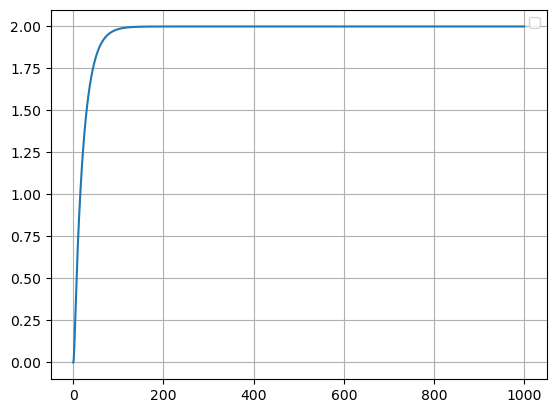

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [177]:
# plot(xhist[1,:],xhist[2,:])
# plot(thist,xhist[2,:], label="r2")
# plot(thist,xhist[3,:], label="r3")
plot(all_x[3,:])
# xlabel("x")
# ylabel("y")

legend()
grid()

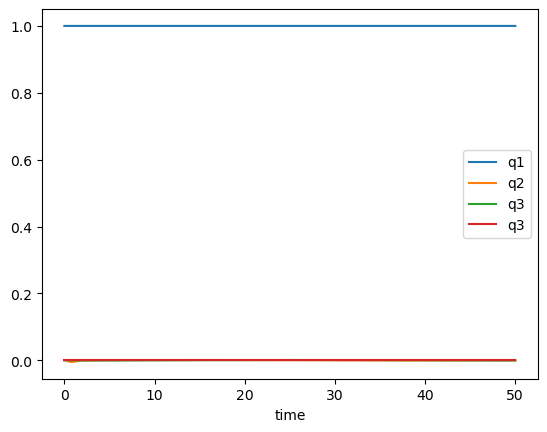

PyObject <matplotlib.legend.Legend object at 0x00000000882AFD90>

In [157]:
plot(thist,all_x[4,:], label="q1")
plot(thist,all_x[5,:], label="q2")
plot(thist,all_x[6,:], label="q3")
plot(thist,all_x[7,:], label="q3")

xlabel("time")
legend()


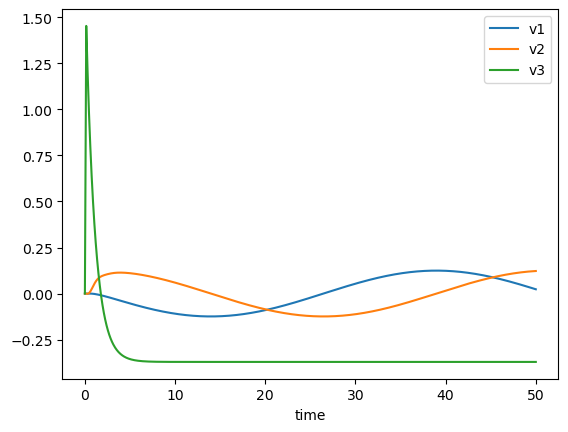

PyObject <matplotlib.legend.Legend object at 0x000000005FA38EE0>

In [158]:
plot(thist,all_x[8,:], label="v1")
plot(thist,all_x[9,:], label="v2")
plot(thist,all_x[10,:], label="v3")

xlabel("time")
legend()


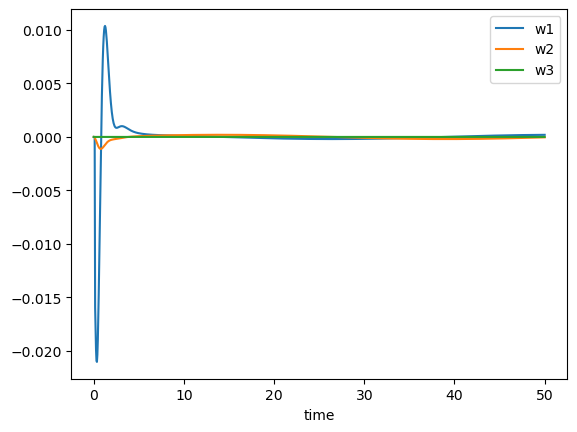

PyObject <matplotlib.legend.Legend object at 0x000000005F9E4310>

In [159]:
plot(thist,all_x[11,:], label="w1")
plot(thist,all_x[12,:], label="w2")
plot(thist,all_x[13,:], label="w3")

xlabel("time")
legend()


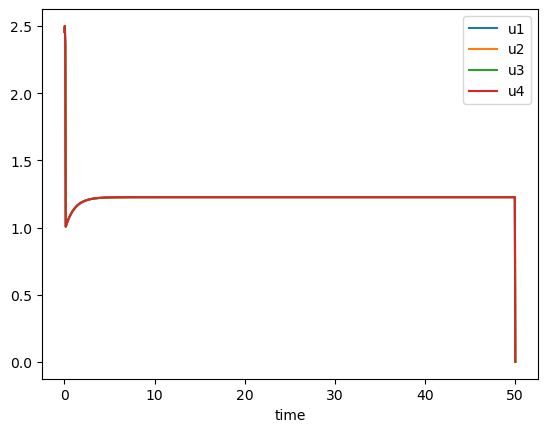

PyObject <matplotlib.legend.Legend object at 0x0000000088172FD0>

In [164]:
plot(thist, all_u[1,:], label = "u1")
plot(thist, all_u[2,:], label = "u2")
plot(thist, all_u[3,:], label = "u3")
plot(thist, all_u[4,:], label = "u4")

xlabel("time")
legend()